Cargando datos... esto puede tardar unos segundos.
¡Datos cargados! Tenemos 87554 latidos registrados.
Cada latido está compuesto por 188 puntos de datos (el último es la etiqueta).


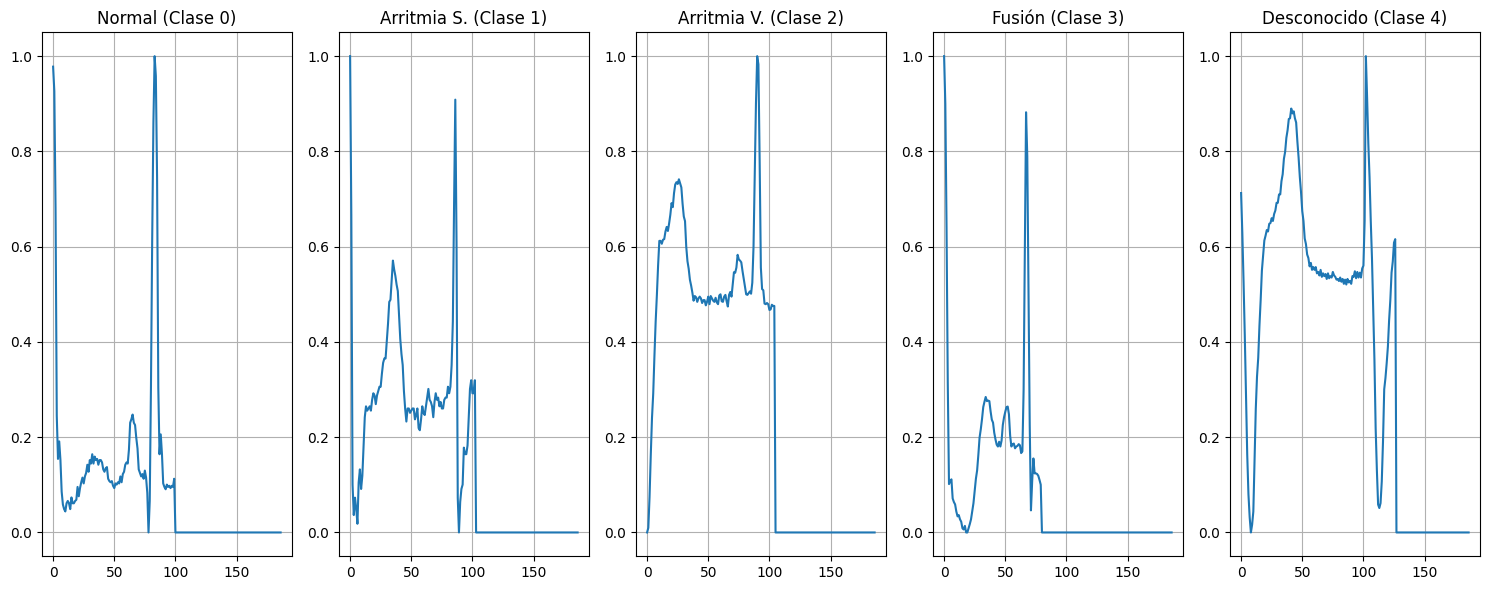


Cantidad de latidos por tipo encontrados:
Normal         72471
Arritmia S.     2223
Arritmia V.     5788
Fusión           641
Desconocido     6431
Name: count, dtype: int64

Cantidad de latidos por tipo:
187
Normal         72471
Desconocido     6431
Arritmia V.     5788
Arritmia S.     2223
Fusión           641
Name: count, dtype: int64


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Cargamos el dataset (asegúrate de que el nombre del archivo coincida)
print("Cargando datos... esto puede tardar unos segundos.")
df = pd.read_csv('sample_data/mitbih_train.csv', header=None)

# 2. Vemos qué forma tiene
print(f"¡Datos cargados! Tenemos {df.shape[0]} latidos registrados.")
print(f"Cada latido está compuesto por {df.shape[1]} puntos de datos (el último es la etiqueta).")

# 3. Mapeo de etiquetas (según la documentación del dataset)
# 0: Normal, 1: Arritmia Supraventricular, 2: Ventricular, 3: Fusión, 4: Desconocido
nombres_clases = {0: 'Normal', 1: 'Arritmia S.', 2: 'Arritmia V.', 3: 'Fusión', 4: 'Desconocido'}

# 4. Vamos a dibujar un ejemplo de cada tipo (CON SEGURIDAD)
plt.figure(figsize=(15, 6))
plot_position = 1

for i in range(5):
    # Primero filtramos
    subset = df[df[187] == i]

    # COMPROBACIÓN DE SEGURIDAD: ¿Hay alguien ahí?
    if len(subset) > 0:
        # Si hay datos, cogemos el primero
        latido = subset.iloc[0, :-1]

        # Dibujamos
        plt.subplot(1, 5, plot_position)
        plt.plot(latido)
        plt.title(f"{nombres_clases[i]} (Clase {i})")
        plt.grid(True)
    else:
        # Si no hay datos, imprimimos un aviso
        print(f"⚠️ No se han encontrado ejemplos de la clase: {nombres_clases[i]}")

        # Creamos un hueco vacío en la gráfica para no romper el diseño
        plt.subplot(1, 5, plot_position)
        plt.text(0.5, 0.5, "Sin datos", ha='center', va='center')
        plt.title(f"{nombres_clases[i]}")

    plot_position += 1

plt.tight_layout()
plt.show()

# 5. Ver cuántos datos tenemos de cada tipo
counts = df[187].value_counts().sort_index()
# Mapeamos los índices a nombres si existen en el diccionario
counts.index = [nombres_clases.get(idx, idx) for idx in counts.index]

print("\nCantidad de latidos por tipo encontrados:")
print(counts)

# 5. Ver cuántos datos tenemos de cada tipo (Desbalanceo)
counts = df[187].value_counts().rename(index=nombres_clases)
print("\nCantidad de latidos por tipo:")
print(counts)

Nuevas cantidades por clase:
187
0.0    20000
1.0    20000
2.0    20000
3.0    20000
4.0    20000
Name: count, dtype: int64


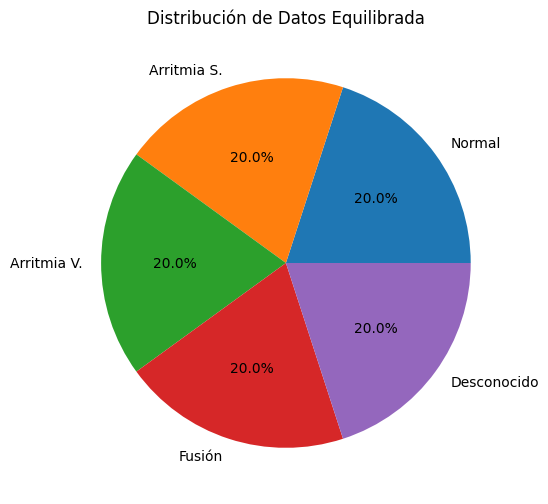

In [17]:
from sklearn.utils import resample

# 1. Separamos el dataframe original por clases
df_0 = df[df[187] == 0] # Normal
df_1 = df[df[187] == 1] # Arritmia S
df_2 = df[df[187] == 2] # Arritmia V
df_3 = df[df[187] == 3] # Fusión
df_4 = df[df[187] == 4] # Desconocido

# 2. Vamos a hacer que todas las clases tengan 20.000 ejemplos
# (Aumentamos las pequeñas y recortamos la gigante)
n_samples = 20000

df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)

# 3. Juntamos todo en un nuevo dataset equilibrado
df_train_balanced = pd.concat([df_0_balanced, df_1_balanced, df_2_balanced, df_3_balanced, df_4_balanced])

# 4. Comprobamos el resultado final
print("Nuevas cantidades por clase:")
print(df_train_balanced[187].value_counts())

# 5. Visualizamos la nueva distribución (Un gráfico de pastel)
plt.figure(figsize=(6,6))
plt.pie(df_train_balanced[187].value_counts(), labels=nombres_clases.values(), autopct='%1.1f%%')
plt.title("Distribución de Datos Equilibrada")
plt.show()

In [18]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 1. Separamos X (señales) e y (etiquetas)
target_col = df_train_balanced.columns[-1] # La última columna (187)
X = df_train_balanced.drop(target_col, axis=1)
y = df_train_balanced[target_col]

# 2. Transformamos los datos para que la Red Neuronal los entienda
# Las CNNs necesitan 3 dimensiones: (Muestras, Pasos de tiempo, Características)
X = X.values.reshape(len(X), X.shape[1], 1)

# 3. Transformamos las etiquetas a formato categórico (One-Hot)
y = to_categorical(y)

# 4. Separamos una parte para "validar" mientras entrena (20% para examinar)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Forma de los datos de entrenamiento:", X_train.shape)
print("Forma de las etiquetas:", y_train.shape)

Forma de los datos de entrenamiento: (80000, 187, 1)
Forma de las etiquetas: (80000, 5)


In [19]:
import numpy as np
from scipy.ndimage import shift
from sklearn.utils import shuffle

# --- PASO NUEVO: AUMENTO DE DATOS ROBUSTO ---
def augment_data_robust(X, y):
    print("🧠 Generando variantes de los latidos (Data Augmentation)...")
    X_aug = []
    y_aug = []

    for i in range(len(X)):
        # 1. El latido original
        X_aug.append(X[i])
        y_aug.append(y[i])

        # 2. Copia movida a la IZQUIERDA (simula latido prematuro)
        # Movemos 15 puntos y rellenamos con 0
        shifted_left = shift(X[i], [-15, 0], cval=0.0)
        X_aug.append(shifted_left)
        y_aug.append(y[i])

        # 3. Copia movida a la DERECHA (simula latido tardío)
        shifted_right = shift(X[i], [15, 0], cval=0.0)
        X_aug.append(shifted_right)
        y_aug.append(y[i])

    return np.array(X_aug), np.array(y_aug)

# Aplicamos la función a tus datos de entrenamiento
# (Asegúrate de que tus variables se llaman X_train y y_train)
print(f"Latidos originales: {len(X_train)}")
X_train_aug, y_train_aug = augment_data_robust(X_train, y_train)

# Mezclamos para que no aprenda en orden
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=42)

print(f"Latidos finales para entrenar: {len(X_train_aug)} (x3 datos)")

Latidos originales: 80000
🧠 Generando variantes de los latidos (Data Augmentation)...
Latidos finales para entrenar: 240000 (x3 datos)


In [20]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

print("⏳ Cargando datos de prueba (Test)...")

# 1. Leemos el archivo de test
test_df = pd.read_csv('sample_data/mitbih_test.csv', header=None)

# 2. Separamos los datos (X) de las etiquetas (y)
# X son todas las columnas menos la última
X_test = test_df.iloc[:, :-1].values
# y es la última columna (el diagnóstico real)
y_test = test_df.iloc[:, -1].values

# 3. Adaptamos la forma para que la CNN lo entienda
# Reshape a (número_muestras, 187, 1)
X_test = X_test.reshape(len(X_test), 187, 1)

# Convertimos las etiquetas a formato categoría (one-hot encoding)
y_test = to_categorical(y_test)

print(f"✅ ¡Listo! Variable X_test creada con {len(X_test)} latidos para validar.")

⏳ Cargando datos de prueba (Test)...
✅ ¡Listo! Variable X_test creada con 21892 latidos para validar.


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout

# 1. Definimos la arquitectura (El esqueleto de la IA)
model = Sequential()

# Capa 1: Ojo experto (detecta patrones simples)
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(187, 1)))
model.add(MaxPool1D(pool_size=2))

# Capa 2: Ojo más experto (detecta patrones complejos)
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPool1D(pool_size=2))

# Capa 3: Aplanar la información para tomar decisiones
model.add(Flatten())

# Capa 4: Neuronas de decisión
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # Apagamos neuronas al azar para evitar memorización

# Capa 5: Salida (5 neuronas, una por cada tipo de arritmia)
model.add(Dense(5, activation='softmax'))

# 2. Compilamos el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. ¡ENTRENAMOS! (Esto tardará un par de minutos)
print("Entrenando la red neuronal... observa cómo sube el 'accuracy'")
# Entrenamos con los datos AUMENTADOS
history = model.fit(
    X_train_aug,      # <--- CAMBIO AQUÍ
    y_train_aug,      # <--- CAMBIO AQUÍ
    epochs=10,        # Con 8-10 épocas suele sobrar porque hay muchos datos
    batch_size=32,
    validation_data=(X_test, y_test)
)

Entrenando la red neuronal... observa cómo sube el 'accuracy'


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 129s 17ms/step - accuracy: 0.7791 - loss: 0.5977 - val_accuracy: 0.9139 - val_loss: 0.2478
Epoch 2/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 125s 17ms/step - accuracy: 0.9145 - loss: 0.2385 - val_accuracy: 0.9251 - val_loss: 0.2242
Epoch 3/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 123s 16ms/step - accuracy: 0.9404 - loss: 0.1675 - val_accuracy: 0.9483 - val_loss: 0.1604
Epoch 4/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 125s 17ms/step - accuracy: 0.9521 - loss: 0.1348 - val_accuracy: 0.9399 - val_loss: 0.1615
Epoch 5/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 127s 17ms/step - accuracy: 0.9589 - loss: 0.1168 - val_accuracy: 0.9591 - val_loss: 0.1454
Epoch 6/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 139s 17ms/step - accuracy: 0.9642 - loss: 0.1013 - val_accuracy: 0.9609 - val_loss: 0.1446
Epoch 7/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 144s 17ms/step - accuracy: 0.9683 - loss: 0.0900 - val_accuracy: 0.9591 - val_loss: 0.1384
Epoch 8/10
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 126s 17ms/step - accuracy: 

Evaluando en el set de test...
685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9683 - loss: 0.1084
Accuracy final en Test: 96.64%
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


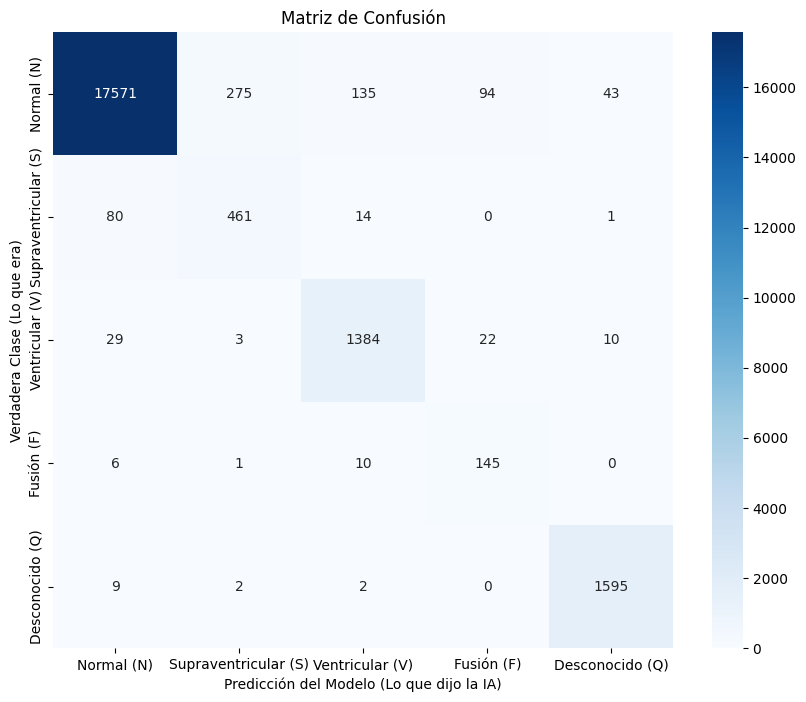

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Cargar los datos de TEST (Nunca vistos por la IA)
test_df = pd.read_csv('sample_data/mitbih_test.csv', header=None)

# 2. Preprocesar igual que hicimos antes (Separar X e y)
test_X = test_df.iloc[:, :-1]
test_y = test_df.iloc[:, -1]

# 3. Darle la forma correcta para la red (Reshape)
test_X = test_X.values.reshape(len(test_X), 187, 1)

# 4. Hacemos las transformaciones de etiquetas
# (OJO: Aquí no usamos to_categorical para la matriz de confusión, queremos el número directo)
# Pero para el 'evaluate' sí lo necesitamos, así que hacemos una copia
test_y_categorical = to_categorical(test_y)

# 5. Evaluación final numérica
print("Evaluando en el set de test...")
results = model.evaluate(test_X, test_y_categorical)
print(f"Accuracy final en Test: {results[1]*100:.2f}%")

# 6. PREDICCIÓN Y MATRIZ DE CONFUSIÓN
# Pedimos al modelo que prediga todo el set de test
predictions = model.predict(test_X)
predicted_classes = np.argmax(predictions, axis=1) # Convertimos probabilidades a etiqueta (0,1,2...)


# Creamos la matriz
cm = confusion_matrix(test_y, predicted_classes)

# 7. Visualización bonita
plt.figure(figsize=(10, 8))
# Eliminamos .values() porque nombres_clases ya es una lista
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nombres_clases,
            yticklabels=nombres_clases)
plt.title('Matriz de Confusión')
plt.ylabel('Verdadera Clase (Lo que era)')
plt.xlabel('Predicción del Modelo (Lo que dijo la IA)')
plt.show()

In [27]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Nombres de las clases
nombres_clases = ['Normal (N)', 'Supraventricular (S)', 'Ventricular (V)', 'Fusión (F)', 'Desconocido (Q)']

# Calcular predicciones si aún no las tienes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)  # Si y_test está en one-hot encoding

# Métricas Globales
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision_macro = precision_score(y_test_classes, y_pred_classes, average='macro')
recall_macro = recall_score(y_test_classes, y_pred_classes, average='macro')
f1_macro = f1_score(y_test_classes, y_pred_classes, average='macro')

print(" Modelo v1:)\n")
print("Métricas Globales:")
print(f"  Accuracy Global: {accuracy:.0%}")
print(f"  Precision Macro Avg: {precision_macro:.2f}")
print(f"  Recall Macro Avg: {recall_macro:.2f}")
print(f"  F1-Score Macro Avg: {f1_macro:.2f}")

print("\n" + "="*60)
print("           RESULTADOS DEL EXAMEN FINAL (TEST SET)")
print("="*60)
print(classification_report(y_test_classes, y_pred_classes, target_names=nombres_clases))

685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
 Modelo v1:)

Métricas Globales:
  Accuracy Global: 97%
  Precision Macro Avg: 0.81
  Recall Macro Avg: 0.93
  F1-Score Macro Avg: 0.86

           RESULTADOS DEL EXAMEN FINAL (TEST SET)
                      precision    recall  f1-score   support

          Normal (N)       0.99      0.97      0.98     18118
Supraventricular (S)       0.62      0.83      0.71       556
     Ventricular (V)       0.90      0.96      0.92      1448
          Fusión (F)       0.56      0.90      0.69       162
     Desconocido (Q)       0.97      0.99      0.98      1608

            accuracy                           0.97     21892
           macro avg       0.81      0.93      0.86     21892
        weighted avg       0.97      0.97      0.97     21892



In [33]:
model.save('modelo_v1.keras')
# 2. (Opcional) Código para descargarlo a tu ordenador automáticamente
from google.colab import files
files.download('modelo_v1.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
import pandas as pd

df = pd.read_csv("sample_data/mitbih_test.csv", header=None)

# Filtrar una ventricular (clase 2)
row = df[df[187] == 2.0].iloc[0]

features = row.iloc[:187]  # señal
label = int(row.iloc[187]) # debería ser 2
print(label)  # para verificar que es ventricular


2


In [35]:
features.to_csv("ventricular_real.csv", index=False, header=False)


In [36]:
import pandas as pd
import os

# Ruta donde quieres guardar los CSV
OUTPUT_DIR = "sample_data/LATIDOS"

# Crear la carpeta si no existe
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Cargar el conjunto de test
df = pd.read_csv("sample_data/mitbih_test.csv", header=None)

# Diccionario de clases
clases = {
    0: "normal",
    1: "supraventricular",
    2: "ventricular",
    3: "fusion",
    4: "desconocido"
}

# Número de nuevos ejemplos que quieres por clase
N_EXAMPLES = 5

for clase_id, clase_nombre in clases.items():
    # Filtrar filas de esa clase
    subset = df[df[187] == clase_id]

    # Saltamos la primera fila (ya usada antes) y cogemos las siguientes N_EXAMPLES
    subset = subset.iloc[1:1 + N_EXAMPLES]

    for i, (_, row) in enumerate(subset.iterrows(), start=1):
        features = row.iloc[:187].values.reshape(1, 187)

        # Ruta completa del archivo dentro de LATIDOS/
        filename = os.path.join(OUTPUT_DIR, f"latido_{clase_nombre}_extra{i}.csv")

        pd.DataFrame(features).to_csv(filename, index=False, header=False)
        print("Guardado:", filename)



Guardado: sample_data/LATIDOS/latido_normal_extra1.csv
Guardado: sample_data/LATIDOS/latido_normal_extra2.csv
Guardado: sample_data/LATIDOS/latido_normal_extra3.csv
Guardado: sample_data/LATIDOS/latido_normal_extra4.csv
Guardado: sample_data/LATIDOS/latido_normal_extra5.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra1.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra2.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra3.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra4.csv
Guardado: sample_data/LATIDOS/latido_supraventricular_extra5.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra1.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra2.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra3.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra4.csv
Guardado: sample_data/LATIDOS/latido_ventricular_extra5.csv
Guardado: sample_data/LATIDOS/latido_fusion_extra1.csv
Guardado: sample_data/LATIDOS/latido_fusion_e

In [37]:
!pip install shap

In [38]:
import shap
import tensorflow as tf

# 1. Seleccionamos un 'fondo' para comparar
# SHAP necesita saber qué es "lo normal". Le damos 100 latidos al azar del entrenamiento.
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# 2. Creamos el Explainer (el "Explicador")
# Usamos DeepExplainer que está optimizado para Deep Learning
explainer = shap.DeepExplainer(model, background)

# 3. Elegimos qué latidos queremos explicar
# Vamos a coger 5 latidos del set de TEST (que la IA no conocía)
# Intentemos coger algunos que sepamos que son arritmias (clase 2 por ejemplo) para ver qué detecta
test_samples = test_X[test_y == 2][:3] # Cogemos 3 ejemplos de Arritmia Ventricular

# 4. Calculamos los valores SHAP (esto puede tardar unos segundos)
print("Calculando explicaciones... (la IA está pensando)")
shap_values = explainer.shap_values(test_samples)

# Nota: shap_values es una lista de 5 arrays (uno por cada posible clase de salida).
# Nos interesa la clase 2 (Arritmia Ventricular) porque son ejemplos de esa clase.
shap_values_target = shap_values[2] # Miramos la explicación para la clase "Arritmia V."

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_37
Received: inputs=['Tensor(shape=(100, 187, 1))']
  warnings.warn(msg)


Calculando explicaciones... (la IA está pensando)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_37
Received: inputs=['Tensor(shape=(200, 187, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_37
Received: inputs=['Tensor(shape=(3, 187, 1))']
  warnings.warn(msg)


Visualizando latido con dimensiones correctas: (187, 1)


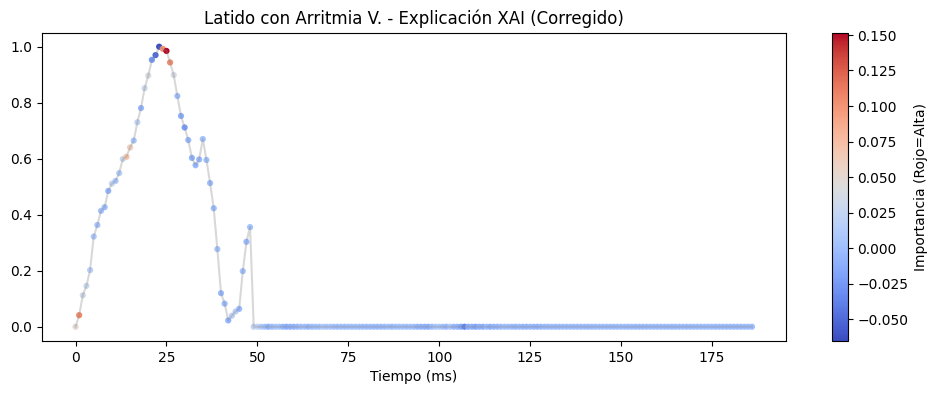

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. DEFINIMOS LA FUNCIÓN DE DIBUJO (La herramienta) ---
def plot_ecg_xai_robust(signal, shap_values, title="Explicación del Modelo"):
    # Aplanamos los datos para evitar errores de dimensión
    signal_flat = np.squeeze(signal)
    shap_flat = np.squeeze(shap_values)

    # Comprobación de seguridad
    if signal_flat.shape != shap_flat.shape:
        print(f"⚠️ Aviso: Ajustando tamaños automáticamente ({signal_flat.shape} vs {shap_flat.shape})")
        min_len = min(len(signal_flat), len(shap_flat))
        signal_flat = signal_flat[:min_len]
        shap_flat = shap_flat[:min_len]

    # Dibujamos
    plt.figure(figsize=(12, 4))
    plt.plot(signal_flat, color='gray', alpha=0.3, label='Señal ECG')

    # Coloreamos según importancia (SHAP)
    shap_min, shap_max = np.min(shap_flat), np.max(shap_flat)
    plt.scatter(range(len(signal_flat)), signal_flat,
                c=shap_flat, cmap='coolwarm',
                s=20, edgecolor='none',
                vmin=shap_min, vmax=shap_max)

    plt.colorbar(label='Importancia (Rojo=Alta)')
    plt.title(title)
    plt.xlabel('Tiempo (ms)')
    plt.show()

# --- 2. PREPARAMOS LOS DATOS (La corrección clave) ---
# Seleccionamos el PRIMER latido de los 3 que calculamos
indice_latido = 0
raw_signal = test_samples[indice_latido]

# AQUI ESTA LA CORRECCIÓN:
# Accedemos a [latido 0] -> [todos los tiempos] -> [canal 0] -> [Clase 2: Arritmia V.]
raw_shap = shap_values[indice_latido][:, 0, 2]

# --- 3. EJECUTAMOS ---
print(f"Visualizando latido con dimensiones correctas: {raw_signal.shape}")
plot_ecg_xai_robust(raw_signal, raw_shap, title="Latido con Arritmia V. - Explicación XAI (Corregido)")